# 1. Import Libraries

In [1]:
import os
import requests
from io import BytesIO
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 2. Load Dataset

### 2.1 Define GitHub Repo & Folder Path

In [2]:
GITHUB_REPO = "prattapong/Commercial-Airplane-Model-Image-Classification"
GITHUB_FOLDER = "images"
GITHUB_API_URL = f"https://api.github.com/repos/{GITHUB_REPO}/contents/{GITHUB_FOLDER}"

### 2.2 Fetch Image URLs and Load Image

In [3]:
# Fetch Image URLs Automatically
def get_image_urls():
    response = requests.get(GITHUB_API_URL)
    if response.status_code != 200:
        raise Exception(f"Error fetching images: {response.json()}")

    image_urls = {}
    for folder in response.json():
        if folder["type"] == "dir":  # Ensure it's a folder (A350, B787, A320)
            class_name = folder["name"]
            image_urls[class_name] = []
            folder_url = folder["url"]

            # Fetch image files in each class folder
            folder_response = requests.get(folder_url)
            if folder_response.status_code == 200:
                for file in folder_response.json():
                    if file["name"].lower().endswith((".jpg", ".jpeg", ".png")):
                        image_urls[class_name].append(file["download_url"])

    return image_urls

# Load Images Using Image.open()
def load_images(image_urls):
    IMG_SIZE = (224, 224)  # Resize all images to 224x224
    X, y = [], []

    for label, urls in image_urls.items():
        for url in urls:
            try:
                response = requests.get(url)
                img = Image.open(BytesIO(response.content)).convert("RGB")  # Load image
                img = img.resize(IMG_SIZE)
                X.append(np.array(img) / 255.0)  # Normalize
                y.append(label)
            except Exception as e:
                print(f"Error loading {url}: {e}")

    return np.array(X), pd.Categorical(y).codes

# 3. Data-preprocessing

In [4]:
def augment_data(X_train):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    datagen.fit(X_train)

    return datagen

# 4. Train model

In [5]:
def train_model(X, y, batch_size:int, epochs:int):
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = 0.2,
        stratify = y,
        random_state = 244
    )

    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    # Add classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(len(set(y)), activation="softmax")(x)  # Output layer for classification

    model = Model(inputs=base_model.input, outputs=x)
    model.build((None, 224, 224, 3))  # Build the model with the input shape
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    datagen = augment_data(X_train)
    checkpoint = ModelCheckpoint('best_airplane_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), validation_data=(X_test, y_test), epochs=epochs, callbacks=[checkpoint])

    best_model = tf.keras.models.load_model('best_airplane_model.h5')
    print("Best model saved as 'best_airplane_model.h5'")

    return best_model

In [6]:
image_urls = get_image_urls()
X, y = load_images(image_urls)
best_model = train_model(
    X = X,
    y = y,
    batch_size = 8,
    epochs = 100
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.3258 - loss: 1.4735
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_airplane_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.3262 - loss: 1.4516 - val_accuracy: 0.3333 - val_loss: 1.1738
Epoch 2/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.2926 - loss: 1.1853
Epoch 2: val_accuracy did not improve from 0.33333
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.2927 - loss: 1.1782 - val_accuracy: 0.3333 - val_loss: 1.0926
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2971 - loss: 1.1110
Epoch 3: val_accuracy did not improve from 0.33333
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.3062 - loss: 1.1089 - val_accuracy: 0.3333 - val_loss: 1.0969
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3287 - loss: 1.1070
Epoch 4: val_accuracy did not improve from 0.33333
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.3324 - loss: 1.1064 - val_accuracy: 0.3333 - val_loss: 1.1040
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3613 - loss: 1.0954
Epoch 5: val_accuracy did not improve from 0.33333
8

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.3496 - loss: 1.0942 - val_accuracy: 0.4667 - val_loss: 1.0838
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3696 - loss: 1.0912
Epoch 7: val_accuracy did not improve from 0.46667
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.3784 - loss: 1.0909 - val_accuracy: 0.4667 - val_loss: 1.0845
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3224 - loss: 1.0935
Epoch 8: val_accuracy did not improve from 0.46667
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.3249 - loss: 1.0938 - val_accuracy: 0.4667 - val_loss: 1.0756
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3769 - loss: 1.0822
Epoch 9: val_accuracy did not improve from 0.46667
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.3695 - loss: 1.0839 - val_accuracy: 0.3333 - val_loss: 1.0788
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3880 - loss: 1.0815
Epoch 10: val_accuracy did not improve from 0.4666

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.3115 - loss: 1.1005 - val_accuracy: 0.6000 - val_loss: 1.0709
Epoch 14/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3077 - loss: 1.0953
Epoch 14: val_accuracy did not improve from 0.60000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.3159 - loss: 1.0945 - val_accuracy: 0.5333 - val_loss: 1.0688
Epoch 15/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4699 - loss: 1.0830
Epoch 15: val_accuracy did not improve from 0.60000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.4460 - loss: 1.0845 - val_accuracy: 0.4667 - val_loss: 1.0700
Epoch 16/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3262 - loss: 1.0932
Epoch 16: val_accuracy did not improve from 0.60000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.3302 - loss: 1.0926 - val_accuracy: 0.4667 - val_loss: 1.0678
Epoch 17/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3661 - loss: 1.0820
Epoch 17: val_accuracy did not improve from 0.

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.5030 - loss: 1.0415 - val_accuracy: 0.6667 - val_loss: 1.0233
Epoch 95/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4646 - loss: 1.0468
Epoch 95: val_accuracy did not improve from 0.66667
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.4628 - loss: 1.0481 - val_accuracy: 0.4667 - val_loss: 1.0225
Epoch 96/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3382 - loss: 1.0859
Epoch 96: val_accuracy did not improve from 0.66667
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.3466 - loss: 1.0822 - val_accuracy: 0.4667 - val_loss: 1.0323
Epoch 97/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5100 - loss: 1.0377
Epoch 97: val_accuracy did not improve from 0.66667
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.5070 - loss: 1.0386 - val_accuracy: 0.4667 - val_loss: 1.0375
Epoch 98/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4737 - loss: 0.9797
Epoch 98: val_accuracy did not improve from 0

Best model saved as 'best_airplane_model.h5'


# 5. Show result of a sample

In [8]:
def show_prediction(model, X, y, index, class_labels):
    """
    Displays an image from X[index] with the model's predicted and actual label.

    Parameters:
    - model: Trained Keras model
    - X: NumPy array of images
    - y: NumPy array of actual labels
    - index: Index of the image to display
    - class_labels: List of class names corresponding to label indices
    """
    sample_image = np.array(X[index])
    sample_input = np.expand_dims(sample_image, axis=0)

    predicted_class = np.argmax(model.predict(sample_input))
    actual_class = y[index]

    predicted_label = class_labels[predicted_class]
    actual_label = class_labels[actual_class]

    # Display the image with prediction
    plt.imshow(sample_image)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}", fontsize=12, color="blue")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


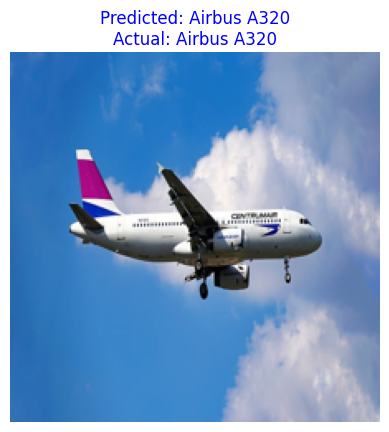

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


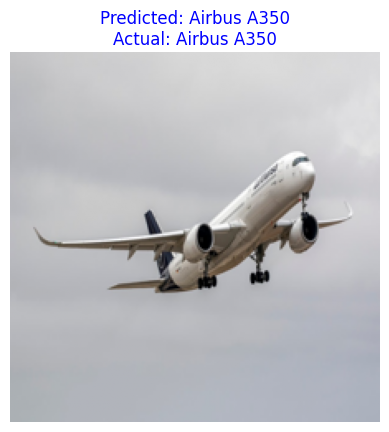

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


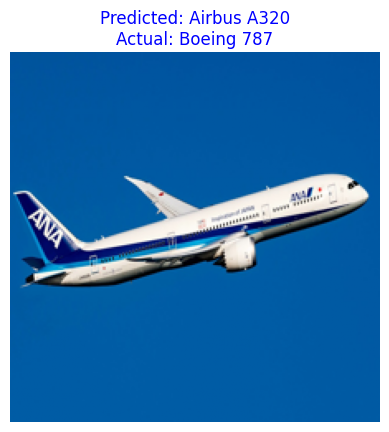

In [11]:
class_labels = ["Airbus A320", "Airbus A350", "Boeing 787"]

for i in [0,32,52]:
    show_prediction(best_model, X, y, index=i, class_labels=class_labels)